# ACS in Mountain Car environment

In [1]:
# Logger
import logging
logging.basicConfig(level=logging.INFO)

import random
import pickle

import pandas as pd
import numpy as np

# Import local paths
import sys, os
sys.path.append(os.path.abspath('../'))
sys.path.insert(0, os.path.abspath('../../openai-envs'))

from lcs import Perception
from lcs.agents import EnvironmentAdapter
from lcs.agents.acs2 import ACS2, Configuration, ClassifiersList
from lcs.metrics import population_metrics

import matplotlib.pyplot as plt
import matplotlib.cm as cm

%matplotlib inline

# Load gyms
import gym
import gym_mountain_car

In [2]:
# papermill params
trials = 50000
decay = True
bins = [10, 100]
biased_exploration=0.01
gamma = 0.95 # that might be important since the reward is far away

## Environment
Description - https://github.com/openai/gym/wiki/MountainCar-v0

![aa](http://gym.openai.com/v2018-02-21/videos/MountainCar-v0-270f34b9-f23e-4d95-a933-4c902b4f4435/poster.jpg)

In [3]:
env = gym.make('MountainCar-v0')
env._max_episode_steps = 1000

_range, _low = (env.observation_space.high - env.observation_space.low, env.observation_space.low)

## Agent configuration

### Discretization of continuous input

In [4]:
class MountainCarAdapter(EnvironmentAdapter):
    BINS = np.array(bins)
    
    @classmethod
    def to_genotype(cls, obs):
        r = (obs + np.abs(_low)) / _range
        b = (r * cls.BINS).astype(int)

        return b.astype(str).tolist()

### Evaluation metric

In [5]:
def avg_fitness(pop):
    return np.mean([cl.fitness for cl in pop if cl.is_reliable()])

# collect more metrics
def mc_metrics(pop, env):
    metrics = {}
    metrics['avg_fitness'] = avg_fitness(pop)
    metrics.update(population_metrics(pop, env))
    
    return metrics

### Building final configuration object

In [6]:
cfg = Configuration(
            classifier_length=2,
            number_of_possible_actions=3,
            epsilon=1.0,
            biased_exploration=biased_exploration,
            beta=0.2,
            gamma=gamma,
            theta_as=50,
            theta_exp=100,
            theta_ga=50,
            do_ga=True,
            mu=0.03,
            chi=0.0,
            metrics_trial_frequency=5,
            user_metrics_collector_fcn=mc_metrics,
            environment_adapter=MountainCarAdapter)

## Experiments

In [7]:
print(f'Running {trials} trials, decay={decay}, bins={bins}\n')
print(cfg)

Running 50000 trials, decay=False, bins=[10, 100]

{'classifier_length': 2, 'number_of_possible_actions': 3, 'classifier_wildcard': '#', 'environment_adapter': <class '__main__.MountainCarAdapter'>, 'metrics_trial_frequency': 5, 'user_metrics_collector_fcn': <function mc_metrics at 0x114153c80>, 'do_pee': False, 'fitness_fcn': None, 'do_ga': True, 'do_subsumption': True, 'do_action_planning': False, 'action_planning_frequency': 50, 'theta_exp': 100, 'beta': 0.1, 'gamma': 0.99, 'theta_i': 0.1, 'theta_r': 0.9, 'epsilon': 0.9, 'biased_exploration': 0.01, 'u_max': 100000, 'theta_ga': 50, 'theta_as': 50, 'mu': 0.03, 'chi': 0.0}


In [8]:
%%time

agent = ACS2(cfg)
population, metrics = agent.explore(env, trials, decay=decay)

/Users/khozzy/miniconda/envs/pyalcs/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/khozzy/miniconda/envs/pyalcs/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
INFO:lcs.agents.Agent:{'trial': 0, 'steps_in_trial': 200, 'reward': -1.0, 'avg_fitness': nan, 'population': 179, 'numerosity': 191, 'reliable': 0}
INFO:lcs.agents.Agent:{'trial': 5000, 'steps_in_trial': 200, 'reward': -1.0, 'avg_fitness': -1.184443706995079, 'population': 1104, 'numerosity': 18753, 'reliable': 33}
INFO:lcs.agents.Agent:{'trial': 10000, 'steps_in_trial': 200, 'reward': -1.0, 'avg_fitness': -1.1522771289902056, 'population': 1153, 'numerosity': 20731, 'reliable': 28}
INFO:lcs.agents.Agent:{'trial': 15000, 'steps_in_trial': 200, 'reward': -1.0, 'avg_fitness': -1.1839653059226556, 'population': 1180, 'numerosity': 22021, 'reliable': 43}

CPU times: user 6h 34min 21s, sys: 30.7 s, total: 6h 34min 51s
Wall time: 6h 35min 38s


In [9]:
# helper function for printing classifier details
def print_cl(cl):
    actions = ['L', '-', 'R']
    action = actions[cl.action]
    
    marked = ''
    
    if cl.is_marked():
        marked = '(*)'
    
    return (f"{cl.condition} - {action} - {cl.effect} [fit: {cl.fitness:.3f}, r: {cl.r:.2f}, q: {cl.q:.2f}, exp: {cl.exp}, num: {cl.num} {marked}]")

In [10]:
reliable = [cl for cl in population if cl.is_reliable()]

print(f"Explore population size: {len(population)}")
print(f"Reliable classifiers: {len(reliable)}\n")

for cl in sorted(reliable, key=lambda cl: -cl.fitness)[:50]:
    print(print_cl(cl))

Explore population size: 1298
Reliable classifiers: 45

471 - - - 570 [fit: -0.992, r: -1.08, q: 0.92, exp: 1, num: 1 ]
567 - L - #65 [fit: -1.006, r: -1.11, q: 0.91, exp: 14, num: 14 ]
141 - L - #42 [fit: -1.017, r: -1.10, q: 0.92, exp: 15, num: 13 ]
326 - R - #27 [fit: -1.039, r: -1.10, q: 0.95, exp: 11, num: 7 ]
228 - - - #29 [fit: -1.058, r: -1.14, q: 0.93, exp: 14, num: 11 ]
140 - L - #41 [fit: -1.061, r: -1.14, q: 0.93, exp: 27, num: 24 ]
146 - L - #47 [fit: -1.085, r: -1.17, q: 0.92, exp: 72, num: 50 ]
230 - - - #31 [fit: -1.101, r: -1.16, q: 0.95, exp: 41, num: 39 ]
546 - L - #44 [fit: -1.132, r: -1.25, q: 0.90, exp: 717, num: 48 ]
446 - L - #45 [fit: -1.137, r: -1.25, q: 0.91, exp: 53632, num: 49 ]
450 - L - #49 [fit: -1.138, r: -1.19, q: 0.95, exp: 79421, num: 49 ]
138 - L - #39 [fit: -1.143, r: -1.22, q: 0.94, exp: 20, num: 20 ]
144 - L - #45 [fit: -1.145, r: -1.22, q: 0.94, exp: 60, num: 49 ]
243 - L - ## [fit: -1.151, r: -1.24, q: 0.93, exp: 6380, num: 48 ]
251 - - - #52 [

In [11]:
metrics_df = pd.DataFrame(metrics)
metrics_df.set_index('trial', inplace=True)

metrics_df.tail()

,steps_in_trial,reward,avg_fitness,population,numerosity,reliable
trial,,,,,,
49975,200,-1.0,-1.188468,1298,26190,44
49980,200,-1.0,-1.181686,1308,26201,45
49985,200,-1.0,-1.173880,1313,26185,46
49990,200,-1.0,-1.180589,1310,26192,52
49995,200,-1.0,-1.182217,1315,26213,46


# Plots

In [12]:
avg_window=int(trials/100)

### Steps in trial

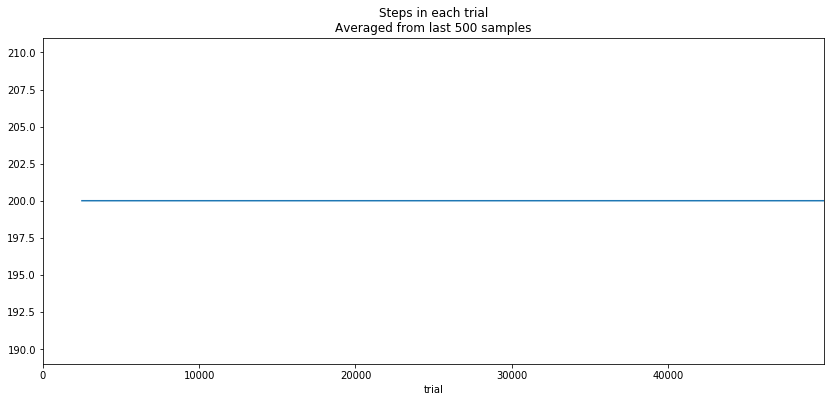

In [13]:
metrics_df['steps_in_trial'].rolling(window=avg_window).mean().plot(figsize=(14,6), title=f'Steps in each trial\nAveraged from last {avg_window} samples');

### Average fitness

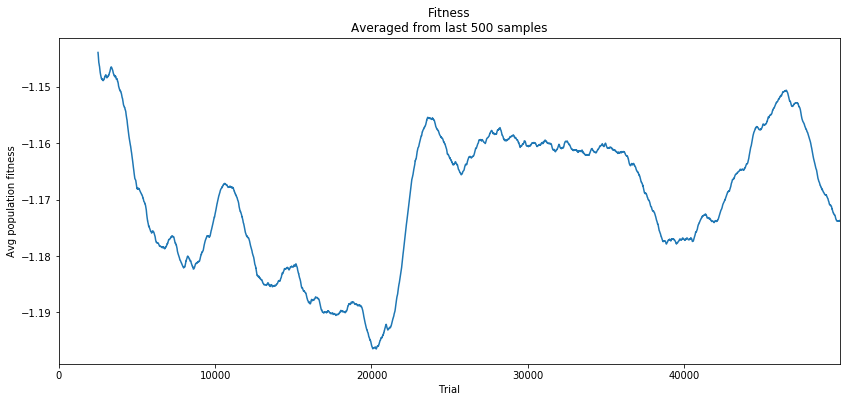

In [14]:
fig, ax = plt.subplots(figsize=(14, 6))

metrics_df['avg_fitness'].rolling(window=avg_window).mean().plot(ax=ax)

ax.set_title(f'Fitness\nAveraged from last {avg_window} samples')
ax.set_xlabel('Trial')
ax.set_ylabel('Avg population fitness')

plt.show()

## Reward

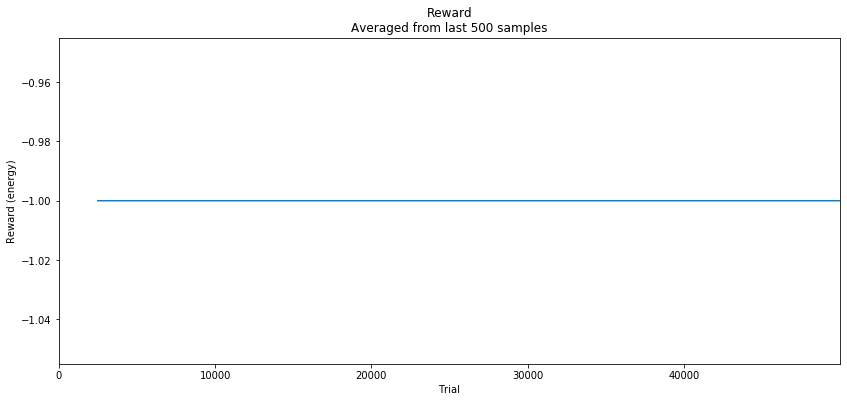

In [15]:
fig, ax = plt.subplots(figsize=(14, 6))

metrics_df['reward'].rolling(window=avg_window).mean().plot(ax=ax)

ax.set_title(f'Reward\nAveraged from last {avg_window} samples')
ax.set_xlabel('Trial')
ax.set_ylabel('Reward (energy)')

plt.show()

## Classifiers

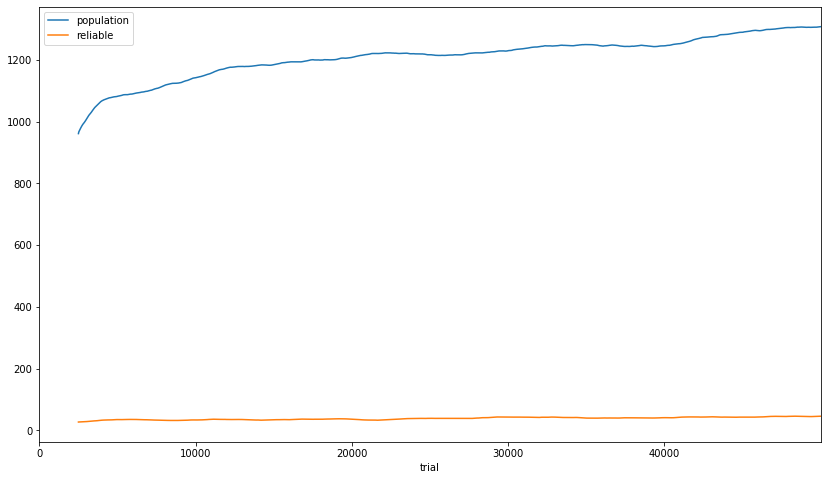

In [16]:
fig, ax = plt.subplots(figsize=(14,8))

metrics_df['population'].rolling(window=avg_window).mean().plot(label='population', ax=ax)
metrics_df['reliable'].rolling(window=avg_window).mean().plot(label='reliable', ax=ax)

plt.legend()
plt.show()

## Policy plot

In [17]:
obs = ("1","1")

def best_action(obs, population):
    matchset = population.form_match_set(Perception(obs))
    anticipated_change_cls = [cl for cl in matchset if cl.does_anticipate_change()]

    best_classifier = None
    if len(anticipated_change_cls) > 0:
        random.shuffle(anticipated_change_cls)
        best_classifier = max(anticipated_change_cls, key=lambda cl: cl.fitness * cl.num)

    if best_classifier is not None:
        return best_classifier.action
    else:
        return None
    
a = best_action(obs, population)
print(a)

2


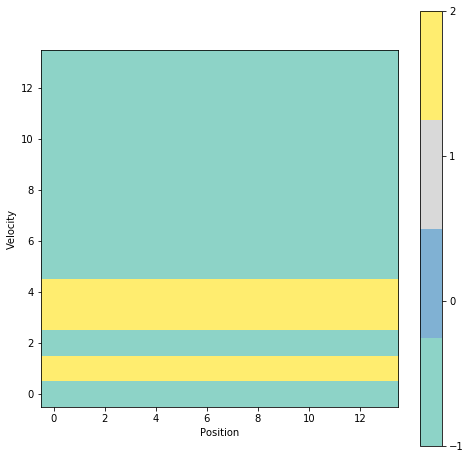

In [18]:
cmap = cm.get_cmap('Set3', 4)

BINS = 14
EMPTY = -1

policy = np.full((BINS, BINS), EMPTY)

for pos_bin in range(BINS):
    for vel_bin in range(BINS):
        obs = (str(pos_bin), str(vel_bin))
        action = best_action(obs, population)
        policy[pos_bin, vel_bin] = action if action != None else EMPTY
        
fig, ax = plt.subplots(figsize=(8,8))
im = ax.imshow(policy, interpolation='none', cmap=cmap);
ax.invert_yaxis()

fig.colorbar(im, ticks=[-1, 0, 1, 2])
plt.xlabel('Position')
plt.ylabel('Velocity')


plt.show();

## Save objects for reproduction

In [19]:
filename = f'mountain_car_{trials}_trials_decay_{decay}_bins_{bins}.pickle'
with open(filename, 'wb') as f:
    pickle.dump((population, metrics_df), f)